# P5 · Maximum common substructure of largest cluster

As described in the previous part, rational drug design often starts from a scaffold, to which substituents will be added or removed. In the previous part a cluster with similar molecules is saved. In this part will from this cluster the maximum common substructure be determined. This maximum common substructure can then be used as scaffold for designing new compounds. 

Import required libraries

In [1]:
from collections import defaultdict
from pathlib import Path
from copy import deepcopy
import random

from ipywidgets import interact, fixed, widgets
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, Geometry
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from rdkit.Chem import PandasTools

import sys
# sys.path.append("../../../")
# import teachopencadd
# from teachopencadd.utils import seed_everything
#
# SEED = 24
# seed_everything(SEED) # fix seed to get deterministic outputs

Define Path to this notebook

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Load and draw molecules

Load the cluster data of the largest cluster from previous part

In [3]:
sdf = str(DATA / "molecule_set_largest_cluster.sdf")
supplier = Chem.ForwardSDMolSupplier(sdf)
mols = list(supplier)

print(f"Set with {len(mols)} molecules loaded.")
# NBVAL_CHECK_OUTPUT

Set with 243 molecules loaded.


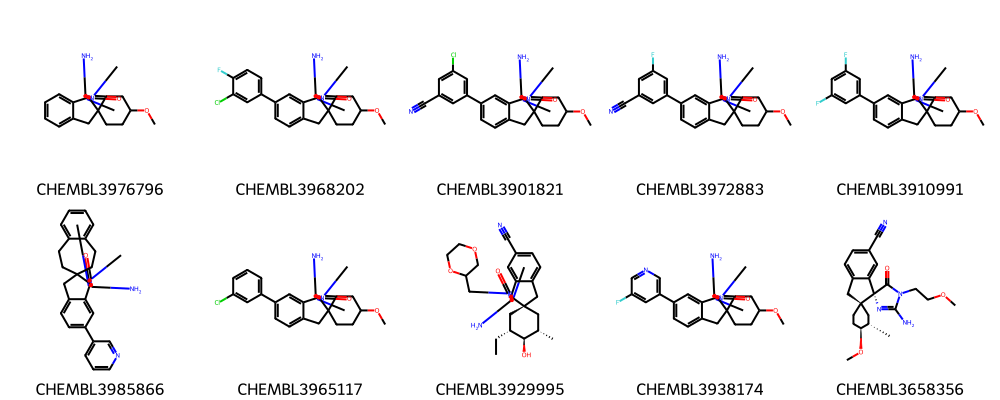

In [4]:
# Show only first 10 molecules -- use slicing
num_mols = 10
legends = [mol.GetProp("_Name") for mol in mols]
Draw.MolsToGridImage(mols[:num_mols], legends=legends[:num_mols], molsPerRow=5)

As can be seen above, the molecules in this cluster are quite similar to each other. 

### Run the FMCS algorithm 

Define a helper function to draw the molecules with the highlighted MCS.

[Wat doet dit algorithm?]

In [5]:
def highlight_molecules(molecules, mcs, number, label=True, same_orientation=True, **kwargs):
    """Highlight the MCS in our query molecules"""
    molecules = deepcopy(molecules)
    # convert MCS to molecule
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    # find the matching atoms in each molecule
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    legends = None
    if label is True:
        legends = [x.GetProp("_Name") for x in molecules]

    # Align by matched substructure so they are depicted in the same orientation
    # Adapted from: https://gist.github.com/greglandrum/82d9a86acb3b00d3bb1df502779a5810
    if same_orientation:
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Draw.MolsToGridImage(
        molecules[:number],
        legends=legends,
        molsPerRow=5,
        highlightAtomLists=matching[:number],
        subImgSize=(200, 200),
        **kwargs,
    )

Perform on the dataset, to get the MCS. This will be done with a treshold of 0.8, which would mean that the MCS has to occur in 80% of the imput structures. Moreover, there is set that ring bonds can only match ringbonds, in order to retain rings. 

[Hoe werkt het om de MCS te bepalen?]

In [6]:
mcs = rdFMCS.FindMCS(mols, threshold=0.8, ringMatchesRingOnly=True) 

# Print the amount of atoms and bonds of the MCS
print(f"MCS contains {mcs.numAtoms} atoms and {mcs.numBonds} bonds.")
print("SMARTS string:", mcs.smartsString)
# NBVAL_CHECK_OUTPUT

MCS contains 23 atoms and 26 bonds.
SMARTS string: [#6&!R]-&!@[#8&!R]-&!@[#6&R]1-&@[#6&R]-&@[#6&R]-&@[#6&R]2(-&@[#6&R]-&@[#6&R]-&@1)-&@[#6&R]-&@[#6&R]1:&@[#6&R](-&@[#6&R]-&@23-&@[#7&R]=&@[#6&R](-&@[#7&R](-&@[#6&R]-&@3=&!@[#8&!R])-&!@[#6&!R])-&!@[#7&!R]):&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@1


###### Draw substructure

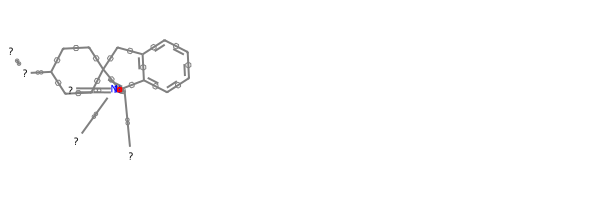

In [7]:
m = Chem.MolFromSmarts(mcs.smartsString)
Draw.MolsToGridImage([m])

Above is the determined MCS drawn. This can be used as scaffold for designing new compounds. This MCS is shown in most of the molecules. Below is this MCS highlighed in some of these molecules. 

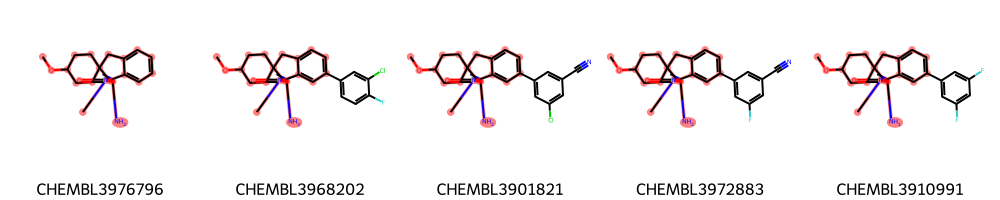

In [8]:
highlight_molecules(mols, mcs, 5)

### Maximum common scaffold of highly active molecules

Instead of determining the scaffold based on the largest cluster, it is also possible to determine the MCS of highly active molecules. To do this, the data will be restricted to only highly active molecules with a pIC50 > 9. From this subset will the MCS be determined.

In [9]:
# Read data
mol_df = pd.read_csv(DATA / "BACE_compounds_part3.csv", index_col=0)
print("Total number of compounds:", mol_df.shape[0])

# Only keep molecules with pIC50 > 9 (IC50 > 1nM)
mol_df = mol_df[mol_df.pIC50 > 9]
print("Number of compounds with pIC50 > 9:", mol_df.shape[0])
# NBVAL_CHECK_OUTPUT

Total number of compounds: 4823
Number of compounds with pIC50 > 9: 68


In [10]:
# Add molecule column to data frame
PandasTools.AddMoleculeColumnToFrame(mol_df, "smiles")
mol_df.head(3)

,molecule_chembl_id,IC50,units,smiles,pIC50,ro5_fulfilled,ROMol
0,CHEMBL3969403,0.0002,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...,12.698970,True,<rdkit.Chem.rdchem.Mol object at 0x7febacbb3d60>
1,CHEMBL3937515,0.0009,nM,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...,12.045757,True,<rdkit.Chem.rdchem.Mol object at 0x7febacbb3d00>
2,CHEMBL3949213,0.0010,nM,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...,12.000000,True,<rdkit.Chem.rdchem.Mol object at 0x7febacbb3ca0>


Calculate on the selected highly active molecules only.

In [11]:
mols_diverse = []
for _, row in mol_df.iterrows():
    m = Chem.MolFromSmiles(row.smiles)
    m.SetProp("_Name", row.molecule_chembl_id)
    mols_diverse.append(m)

There will be three variants of MCSs be determined. The first is the MCS. The second is the MCS with a threshold of 0.7, meaning  that the MCS only has to occur in 70% of the molecules. This treshold will be lower than in the previous part with the largest cluster, to account for the larger diversity in this set. The thirth MCS will be a MCS with the same treshold, but also with in this case ring bonds can only match ringbonds, in order to retain rings. 

In [12]:
threshold_diverse = 0.7
mcs1 = rdFMCS.FindMCS(mols_diverse)
print("SMARTS string1:", mcs1.smartsString)
mcs2 = rdFMCS.FindMCS(mols_diverse, threshold=threshold_diverse)
print("SMARTS string2:", mcs2.smartsString)
mcs3 = rdFMCS.FindMCS(mols_diverse, ringMatchesRingOnly=True, threshold=threshold_diverse)
print("SMARTS string3:", mcs3.smartsString)
# NBVAL_CHECK_OUTPUT

SMARTS string1: [#6]-,:[#6](-,:[#6]:,-[#6]:,-[#6]:,-[#6])-,:[#7]
SMARTS string2: [#6]-[#6](-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)(-[#6])-[#7]=[#6]-[#7]
SMARTS string3: [#6&R](-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@1)-,:;@[#6&R]


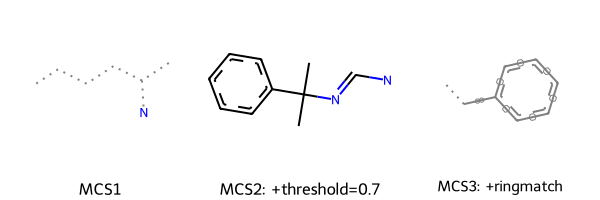

In [13]:
# Draw substructures
m1 = Chem.MolFromSmarts(mcs1.smartsString)
m2 = Chem.MolFromSmarts(mcs2.smartsString)
m3 = Chem.MolFromSmarts(mcs3.smartsString)

Draw.MolsToGridImage(
    [m1, m2, m3],
    legends=[
        "MCS1",
        f"MCS2: +threshold={threshold_diverse}",
        "MCS3: +ringmatch",
    ],
)

As can be seen are these MCS a lot smaller than the previous one of the largest cluster. The thirth MCS is only a phenyl group, which is to few to call it a scaffold to build on. Therefore the MCS of the largest cluster could better be used as scaffold for the design of new compounds.